# Identification of highly active compounds MoA

Cells were treated with various compounds, some have known mode of action (MoA), and some have unknown ones. Negative controls were produced by treating cells with Dimethylsulfoxide (DMSO), which has no MoA. The objective of the following data analysis is to facilitate identification of new MoAs by:
- determining which compounds seem to have a significant activity, and therefore would deserve to be further investigated first.
- determining which compounds with unknown MoA seem to have similar MoA

One way to identify highly active compounds would be to compare their effect to the effect of DMSO, which is the nagative control. In order to do this, we aim at comparing the embeddings of images of cells treated with each compound, to the embeddings of images of cells treated with DMSO, using distance based metrics. Embedding vecotrs that are close to those obtained with DMSO are the ones with the lowest activity, while those that are far away are the most highly active. 

To determine which unknown MoA compounds seem to have similar MoA, we could try to cluster embeddings, aiming for clusters overlapping well with known MoAs. 

In [2]:
#we first import the required packages
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns
import random
import altair as alt


import warnings
warnings.filterwarnings('ignore')



In [3]:
#we load the embeddings
file_name = 'bbbc021_image_embed_compact_batchcorr.csv'
df = pd.read_csv(file_name)

#let's replace Metadata_MoA NaN values by 'unknown'
df['Metadata_MoA'] = df['Metadata_MoA'].fillna(value = 'unknown')


df.head()


,Metadata_PlateNumber,Metadata_ID,Metadata_TableNumber,Metadata_ImageNumber,Metadata_Replicate,Metadata_Compound,Metadata_Concentration,Metadata_SMILES,Metadata_MoA,Z000_DAPI,...,Z1014_Actin,Z1015_Actin,Z1016_Actin,Z1017_Actin,Z1018_Actin,Z1019_Actin,Z1020_Actin,Z1021_Actin,Z1022_Actin,Z1023_Actin
0,27481,4_233,4,233,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown,0.000048,...,0.454990,0.134093,-0.183729,-0.274622,-0.334495,1.243070,-0.255104,0.963327,-0.121460,-0.326638
1,27481,4_234,4,234,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown,0.000206,...,0.092730,0.190641,-0.165633,0.213599,0.029494,1.540971,-0.525035,1.661467,0.396143,-0.416450
2,27481,4_235,4,235,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown,0.000031,...,0.616472,0.227196,-0.220849,-0.269494,-0.428935,1.160149,-0.225761,0.551435,-0.046371,-0.471649
3,27481,4_236,4,236,1,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown,0.000046,...,0.285652,0.394520,-0.290574,-0.200597,-0.159741,0.774231,-0.249552,1.224972,-0.016013,-0.381165
4,27521,4_473,4,473,2,5-fluorouracil,0.003,FC1=CNC(=O)NC1=O,unknown,0.000330,...,-0.020315,0.140883,-0.109927,0.289298,-0.066874,1.750260,-0.640512,1.972492,0.889125,-0.850808


In [4]:
df.Metadata_Compound.unique()

array(['5-fluorouracil', 'acyclovir', 'AG-1478', 'ALLN', 'aloisine A',
       'alsterpaullone', 'anisomycin', 'aphidicolin',
       'arabinofuranosylcytosine', 'atropine', 'bleomycin', 'bohemine',
       'brefeldin A', 'bryostatin', 'calpain inhibitor 2 (ALLM)',
       'calpeptin', 'camptothecin', 'carboplatin',
       'caspase inhibitor 1 (ZVAD)', 'cathepsin inhibitor I',
       'Cdk1 inhibitor III', 'Cdk1/2 inhibitor (NU6102)', 'chlorambucil',
       'chloramphenicol', 'cisplatin', 'colchicine', 'cyclohexamide',
       'cyclophosphamide', 'cytochalasin B', 'cytochalasin D',
       'demecolcine', 'deoxymannojirimycin', 'deoxynojirimycin',
       "3,3'-diaminobenzidine", 'docetaxel', 'doxorubicin', 'emetine',
       'epothilone B', 'etoposide', 'filipin', 'floxuridine', 'forskolin',
       'genistein', 'H-7', 'herbimycin A', 'hydroxyurea', 'ICI-182,780',
       'indirubin monoxime', 'jasplakinolide', 'lactacystin',
       'latrunculin B', 'leupeptin', 'LY-294002', 'methotrexate',
     

## 1) Dimensionality reduction
The image embeddings consist in more than 3000 features. We want to apply dimensionality reduction to both reduce the number of features, and to apply whitening which will help removing the noise from the picture embeddings. We will apply PCA with whitening, and keep the 64 to 256 first principal components to proceed with the vector similarity measurements. To ensure we remove the noise from the pictures, we will fit the PCA on the pictures obtained with DMSO only, and then transform the whole dataset.

In [5]:
#first we select the features that are important (i.e. the embeddings themselves) in the dataframe
data = df.iloc[:, 9:]

#then we normalize the data
sc = StandardScaler()
data = sc.fit_transform(data)

#we transform back the np.array into a pd.DataFrame, and add the compound column to be able to select those which correspond to DMSO
df_pca = pd.DataFrame(data)
df_pca['compound'] = df.Metadata_Compound
df_pca['moa'] = df.Metadata_MoA
df_pca

#now we select only the ones corresponding to DMSO
df_dmso = df_pca[df_pca.compound == 'DMSO']

#and we use it to fit the PCA, either with the first 64, 128, or 256 first principal components
pca_list = []
for n in [32, 64, 128, 256]:
    pca = PCA(n_components=n, whiten = True)
    pca.fit(df_dmso.iloc[:, :-2])
    pca_list.append(pca)

#and we transform the three datasets into a pd.DataFrame again, and append the compounds column
df_pca_list = []
for pca in pca_list:
    df_ = pd.DataFrame(pca.transform(data))
    df_['compound'] = df.Metadata_Compound
    df_['moa'] = df.Metadata_MoA
    df_pca_list.append(df_)


Let's now have a look at the cumulated explained variance ratio of each pca object we've created. We will plot the cumulated explained variance ratio of the four pca (with 32, 64, 182 and 256 first components respectively) as bar chart.

''

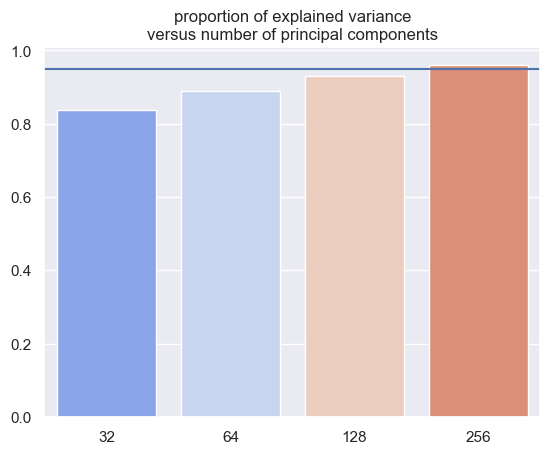

In [6]:
sns.set()
sns.barplot([32, 64, 128, 256], [pca_list[n].explained_variance_ratio_.sum() for n in range(4)], palette="coolwarm")
plt.axhline(y = 0.95) #we add a horizontal line at .95% so better visualize which pca reach 95% of explained variance
plt.title('proportion of explained variance\nversus number of principal components')
;


We can see that only the pca with the first 256 principal components explain more than 95% of the variance of the original dataset. We will therefore proceed with the 256 first principal components. 

## 2) Compound activity estimation by comparison to DMSO
We will now calculate the difference in the principal components vectors of the different compounds, with the principal components vectors of DMSO. For this, we will group the dataset by compound, and average the vectors for each compound. Then, we will measure the euclidian distance and cosine similarity betwen the average pca vector of each compound and the average pca vector of DMSO.

In [7]:
#we first extract the dataframe which contains the 256 first principal components
df_reduced = df_pca_list[3]

#we first calculate the mean vector for each compound
df_mean = df_reduced.groupby('compound').mean().reset_index() 

#then we group the mean vector into a single column of the DataFrame 
df_mean['mean_vector'] = df_mean.apply(lambda x: np.array([x[n] for n in list(range(0, df_mean.shape[1] - 1))]), axis = 1) 

#we now remove the individual values to simplify the dataframe
df_mean = df_mean[['compound','mean_vector']]

#we now locate the vector corresponding to DMSO
mean_vector_DMSO = df_mean[df_mean.compound == 'DMSO'].iloc[0].mean_vector

#and we calculate the euclidian distance between this vector and each compound vector
df_mean['euclidian_distance'] = df_mean.mean_vector.apply(lambda x: euclidean(x, mean_vector_DMSO))

df_mean.head()

,compound,mean_vector,euclidian_distance
0,"3,3'-diaminobenzidine","[0.8589102699991594, -0.48769649360065387, -0....",4.268633
1,5-fluorouracil,"[-0.0990974325031868, -0.40368144967188485, -0...",4.071173
2,AG-1478,"[0.3280934898659407, -0.17783801044816638, -0....",3.587825
3,ALLN,"[0.8707937883627138, -0.4701948340168646, 0.22...",6.694387
4,AZ-A,"[0.5240839761381622, -0.5917490510193472, -0.6...",18.134123


In [8]:
#let's now plot the euclidian distance of each compound with DMSO

# sns.barplot(df_mean.sort_values('euclidian_distance').compound, df_mean.sort_values('euclidian_distance').euclidian_distance)

bar = alt.Chart(df_mean).mark_bar(size = 10).encode(
    x = alt.X('euclidian_distance:Q',
             axis = alt.Axis(
             title = 'Euclidian distance with DMSO'), scale=alt.Scale(padding=0)),
    y = alt.Y('compound:N',
             axis = alt.Axis(title = ''), sort='-x', scale=alt.Scale(padding=0)))

bar

alt.Chart(...)

We can see that the distance with DMSO varies between 3 and 22. We will arbitrarily segment the compounds into three categories:
- The low activity ones: with an euclidian distance with DMSO below 5
- The moderately active ones: euclidian distance with DMSO superior or equal to 5 and blow 10
- The highly active ones: euclidian distance with DMSO superior or equal to 10

Then, let's identify the compounds with unknown MoAs, with high and moderate activity. These would be deserved to be investigated first by researchers for identification of MoA.

In [9]:
#let's label compounds as lowly, moderately, and highly active
def map_activity(x):
    if x < 5 :
        return 'low'
    elif x >= 10:
        return 'high'
    else:
        return 'moderate'

df_mean['activity'] = df_mean.euclidian_distance.apply(lambda x: map_activity(x))
df_mean.head()

,compound,mean_vector,euclidian_distance,activity
0,"3,3'-diaminobenzidine","[0.8589102699991594, -0.48769649360065387, -0....",4.268633,low
1,5-fluorouracil,"[-0.0990974325031868, -0.40368144967188485, -0...",4.071173,low
2,AG-1478,"[0.3280934898659407, -0.17783801044816638, -0....",3.587825,low
3,ALLN,"[0.8707937883627138, -0.4701948340168646, 0.22...",6.694387,moderate
4,AZ-A,"[0.5240839761381622, -0.5917490510193472, -0.6...",18.134123,high


In [10]:
#first let's make a list of highly active compounds
highly_active = df_mean[df_mean.activity == 'high'].compound

#and of moderately active compounds
moderately_active = df_mean[df_mean.activity == 'moderate'].compound

#then let's identify the compounds with unknown MoA in the original dataframe, which are highly and moderately active:
highly_active_unknown_MoA = df[(df.Metadata_MoA == 'unknown') & (df.Metadata_Compound.isin(highly_active))].Metadata_Compound.unique()
moderately_active_unknown_MoA = df[(df.Metadata_MoA == 'unknown') & (df.Metadata_Compound.isin(moderately_active))].Metadata_Compound.unique()

print('compounds with unknown MoA and with a suspected high activity:\n{}'.format(highly_active_unknown_MoA))
print('\n')
print('compounds with unknown MoA and with a suspected moderate activity:\n{}'.format(moderately_active_unknown_MoA))

compounds with unknown MoA and with a suspected high activity:
['aphidicolin' 'chloramphenicol' 'deoxymannojirimycin' 'doxorubicin'
 'filipin' 'rapamycin' 'staurosporine' 'trichostatin' 'valproic acid'
 'vinblastine' 'AZ-L']


compounds with unknown MoA and with a suspected moderate activity:
['bleomycin' 'brefeldin A' 'Cdk1/2 inhibitor (NU6102)' 'genistein' 'H-7'
 'herbimycin A' 'ICI-182,780' 'indirubin monoxime' 'jasplakinolide'
 'nystatin' 'okadaic acid' 'raloxifene' 'SB-203580' 'SP-600125'
 'tunicamycin' 'UO-126' 'Y-27632' 'AZ235' 'AZ-H' 'AZ-I' 'AZ-M' 'AZ-N'
 'TKK']


We have identified which compounds would deserve to be investigated first for determintation of MoA. Recommendation would be to focus first on aphidicolin, chloramphenicol, deoxymannojirimycin, doxorubicin, filipin, rapamycin, staurosporine, trichostatin, valproic acid, vinblastine, and AZ-L. These compounds have a suspected high activity based on measurement of euclidian distance with the embeddings generated from the negative control (DMSO).


## Clustering of embeddings
Now we have reduced the dataset to its 256 first principal components, and determined which compounds had a significant activity (high or moderate), we can attempt clustering the embeddings principal components. The objective is to achieve a clustering which overlaps well with the known MoAs. If we achieve such a clustering, we will be confident that the clusters were made based on MoA. This would mean that compounds with unknown MoA which end up in the same cluster would be likely to have a similar MoA, which would further facilitate the investigation of unknown MoAs.

Based on our qualitative inquiry, centroid-based clustering techniques are the ones making the most sense for clustering of such a dataset. There is no underlying tree structure between MoAs, which excludes hierarchical clustering. Distribution-based clustering was also not recommended, as it is difficult to estimate if an underlying distribution is present over that many features. We will therefore rely on Kmeans clustering.

We will first create a function that screens over the different hyperparameters of the Kmeans algorithm, in order to find the optimal clustering that overlaps the most with known MoAs.

First, we will determine the range of number of clusters that seems to make sense investigating. We will start with one cluster per known MoA + 1 (for unknown ones), and screen up to 2x the number of known MoAs (this is a bit arbitrary, but we need an upper limit, and it is unlikely that we have twice more MoAs in the unknown ones than in the known ones given the proportion of unknown ones).

In [11]:
n_comp =  len(df[(df.Metadata_Compound.isin(highly_active)) | (df.Metadata_Compound.isin(moderately_active))].Metadata_MoA.unique())
print('there are {} unique MoA that are caused by either highly or moderately active compounds'.format(n_comp))

n_high = len(df[df.Metadata_Compound.isin(highly_active)].Metadata_MoA.unique())
print('there are {} unique MoA that are caused by highly active compounds'.format(n_high))


there are 13 unique MoA that are caused by either highly or moderately active compounds
there are 8 unique MoA that are caused by highly active compounds


In [191]:
def scout_kmeans(df, n_cluster, init , max_iter , random_state = 0):
    """Scouts Kmeans and stores the results of each trial in a dataframe that is returned by the function.
    The dataframe contains the Kmeans paramters as well as the percentage of overlap between mode of action and 
    cluster found
    Arguments:
        - df: the dataframe that contains the embedding data
        - n_cluster: list. The values to be tested for hyperparameter n_cluster
        - init: list. The values to be tested for hyperparameter init
        - max_iter: list. The values to be tested for hyperparameter max_iter
    Returns:
        - summary_df: pd.DataFrame object. Contains the combinations of kmeans hyperparameters tested and 
          the resulting overlap between clusters and MoA"""
    
    #get the values of interest from the df
    matrix = df.iloc[:, :-2].values
       
    #create a dictionary to store the overlaps between clusters and MoA
    overlap_dict = {}
    for moa in df.moa.unique():
        overlap_dict[moa] = []
    
    #create 3 lists to store the combination of hyperparameters
    cluster_list = []
    init_list = []
    max_iter_list = []
    
    for cluster in n_cluster:
        for i in init:
            for iter_ in max_iter:
                print('testing {} clusters, {} inits, {} max_iter'.format(cluster, i, iter_))
                
                #update the lists
                cluster_list.append(cluster)
                init_list.append(i)
                max_iter_list.append(iter_)
                
                #create the kmeans object
                km = KMeans(n_clusters = cluster, init = i, max_iter = iter_, random_state = random_state)
                km.fit(matrix)
                labels = km.labels_
                
                #update df with labels
                df_copy = df.copy()
                df_copy['cluster'] = labels
                
                #calculate percent overlap between clusters and known MoAs
                overlap = df_copy.groupby('moa')['cluster'].apply(lambda x: x.value_counts().iloc[0])/df_copy.groupby('moa').count()[0]
                
                #store each overlap in the overlap lists
                for n in range(len(overlap)):
                    overlap_dict[overlap.index[n]].append(overlap[n])
                    
    #create a DataFrame to store kmeans hyperparameters               
    summary_df = pd.DataFrame({**{'n_cluster': cluster_list,
                               'init' : init_list,
                               'max_iter': max_iter_list}, **overlap_dict})
    


                   
    return summary_df
                
#we first include only highly active compounds-induced MoAs
summary_df_high = scout_kmeans(df_reduced[df_reduced.compound.isin(highly_active)], 
                               [i for i in range(10, 18)],
                               ['k-means++', 'random'], 
                               [300], 
                               random_state = 0)
summary_df_high.to_pickle('summary_df_high')

#and we include highly and moderately active compounds-induced MoAs
summary_df_high_moderate = scout_kmeans(df_reduced[(df_reduced.compound.isin(highly_active)) | (df_reduced.compound.isin(moderately_active))],
                                        [i for i in range(14, 26)], 
                                        ['k-means++', 'random'], 
                                        [300], 
                                        random_state = 0)
summary_df_high_moderate.to_pickle('summary_df_high_moderate')

testing 10 clusters, k-means++ inits, 300 max_iter
testing 10 clusters, random inits, 300 max_iter
testing 11 clusters, k-means++ inits, 300 max_iter
testing 11 clusters, random inits, 300 max_iter
testing 12 clusters, k-means++ inits, 300 max_iter
testing 12 clusters, random inits, 300 max_iter
testing 13 clusters, k-means++ inits, 300 max_iter
testing 13 clusters, random inits, 300 max_iter
testing 14 clusters, k-means++ inits, 300 max_iter
testing 14 clusters, random inits, 300 max_iter
testing 15 clusters, k-means++ inits, 300 max_iter
testing 15 clusters, random inits, 300 max_iter
testing 16 clusters, k-means++ inits, 300 max_iter
testing 16 clusters, random inits, 300 max_iter
testing 17 clusters, k-means++ inits, 300 max_iter
testing 17 clusters, random inits, 300 max_iter
testing 14 clusters, k-means++ inits, 300 max_iter
testing 14 clusters, random inits, 300 max_iter
testing 15 clusters, k-means++ inits, 300 max_iter
testing 15 clusters, random inits, 300 max_iter
testing 16

Let's now plot the overlap between each MoA and the respective main cluster as a heatmap, to better visualize which KMeans parameters allowed for the best MoA coverage. First let's do it for the highly active compounds only.

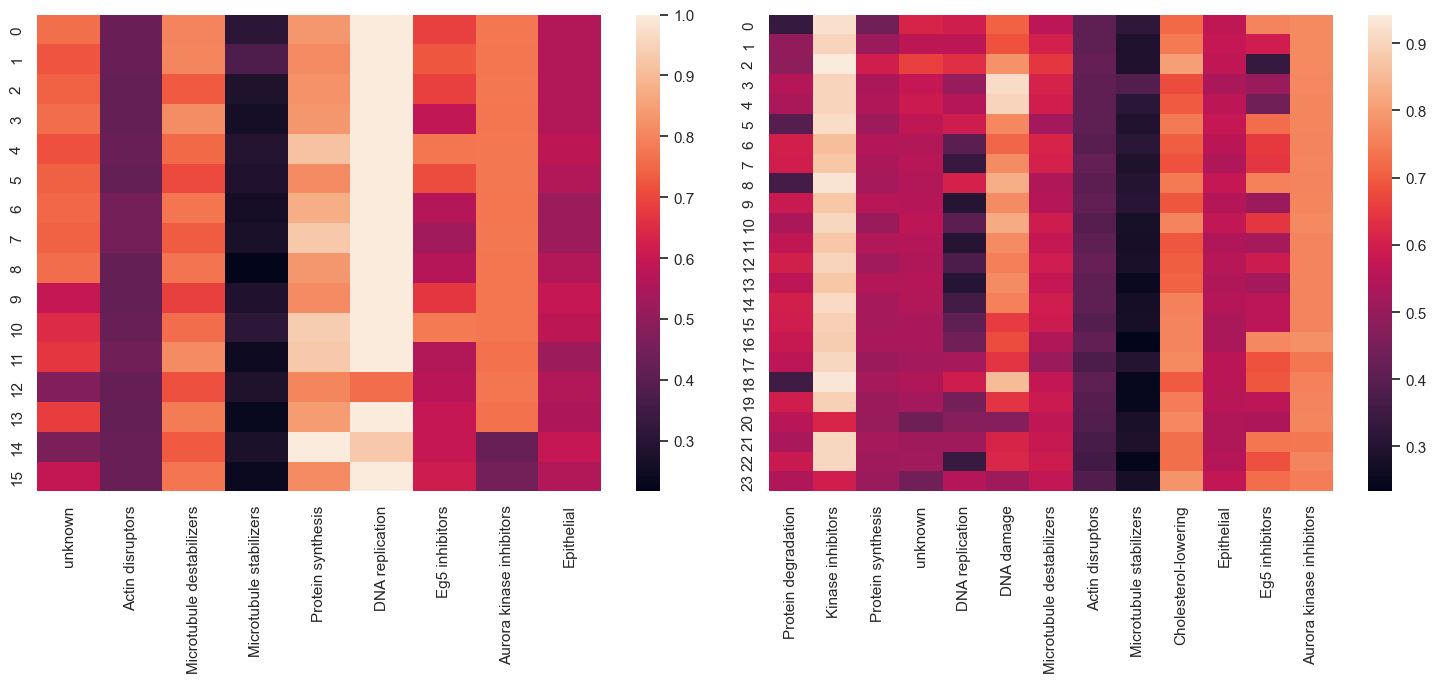

In [41]:
summary_df_high = pd.read_pickle('summary_df_high')
summary_df_high_moderate = pd.read_pickle('summary_df_high_moderate')
fig, ax = plt.subplots(1,2, figsize=(15, 7))
sns.heatmap(summary_df_high.iloc[:, 3:], ax = ax.flatten()[0])
sns.heatmap(summary_df_high_moderate.iloc[:, 3:], ax = ax.flatten()[1])
fig.tight_layout()

In [28]:
summary_df_high

,n_cluster,init,max_iter,unknown,Actin disruptors,Microtubule destabilizers,Microtubule stabilizers,Protein synthesis,DNA replication,Eg5 inhibitors,Aurora kinase inhibitors,Epithelial
0,10,k-means++,300,0.762931,0.430556,0.798611,0.307836,0.833333,1.000000,0.687500,0.777778,0.562500
1,10,random,300,0.718750,0.430556,0.802083,0.378109,0.812500,1.000000,0.723958,0.774306,0.562500
2,11,k-means++,300,0.740302,0.420139,0.729167,0.279229,0.822917,1.000000,0.687500,0.777778,0.562500
3,11,random,300,0.758621,0.420139,0.815972,0.260572,0.833333,1.000000,0.588542,0.774306,0.562500
4,12,k-means++,300,0.713362,0.427083,0.753472,0.292910,0.916667,1.000000,0.776042,0.777778,0.583333
5,12,random,300,0.738147,0.420139,0.704861,0.284204,0.812500,1.000000,0.708333,0.777778,0.562500
6,13,k-means++,300,0.752155,0.451389,0.774306,0.261194,0.875000,1.000000,0.567708,0.774306,0.520833
7,13,random,300,0.741379,0.451389,0.732639,0.271766,0.927083,1.000000,0.531250,0.777778,0.520833
8,14,k-means++,300,0.760776,0.420139,0.770833,0.217040,0.833333,1.000000,0.567708,0.774306,0.562500
9,14,random,300,0.595905,0.420139,0.687500,0.281716,0.812500,1.000000,0.671875,0.774306,0.593750


When considering both highly and moderately active compounds, we have some good overlap between some MoA (DNA damage, Kinase inhibitor) and clusters, but for the majority of MoAs, the overlapping remains low. Interpretation of these clusters is therefore difficult. 

When considering the highly active compounds only, we seem to have a high overlap between the main clusters for each MoA and the associated MoA, except for Microtubule stabilizers and Actin disruptors. This could be explained by the fact that actin filaments and microtubules are both part of the cytoskeleton, which means they are distributed evenly inside the cell, making pictures of MoA related to them not very specific. However, Microtubule destabilizing compounds seem to have a characteristic signature on the cells pictures. 
We achieved the highest overlap between MoA and clusters across the largest set of MoAs with conditions 4: 
- 12 clusters
- k-means ++ initialization
- 300 max iterations

A second good overlap was achieved with the following conditions:
- 15 clusters
- k-means ++ initialization
- 300 max iterations

Let's create a function to have a closer look at the unknown MoA cluster distribution under these two KMeans conditions

In [44]:
def explore_clusters(df, n_clusters, init, max_iter, random_state):
    """
    
    """

    #we fit the kmeans under selected conditions
    km = KMeans(n_clusters = n_clusters, init = init, max_iter = max_iter, random_state = random_state)
    km.fit(df.iloc[:,:-2].values)
    labels = km.labels_

    #update df with labels
    df['cluster'] = labels
    
    return df

df = explore_clusters(df_reduced[df_reduced.compound.isin(highly_active)], n_clusters = 12, init = 'k-means++', max_iter = 300, random_state = 0)
df.groupby(['moa']).cluster.value_counts()


moa                        cluster
Actin disruptors           1          129
                           11          73
                           3           68
                           10          15
                           4            2
                           7            1
Aurora kinase inhibitors   5          222
                           1           49
                           11          12
                           9            3
                           4            2
DNA replication            1           96
Eg5 inhibitors             10         139
                           1           26
                           7           15
                           9            9
                           4            3
Microtubule destabilizers  2          182
                           10          67
                           1           39
Microtubule stabilizers    8          451
                           6          426
                           0          253

Based on the clusters overlap, we can confidently link the following clusters to the following MoAs:
- Microtubule destabilizers : Cluster 2
- Protein synthesis	: Cluster 4
- DNA replication : Cluster 1
- Eg5 inhibitors : Cluster 10
- Aurora kinase inhibitors : Cluster 5

For remaining MoA, clusters overlapping is not sufficient to be confident on the cluster interpretation. Still, with this partial cluster interpretation, we can conclude that among the pictures with unknown MoA, there seems to be 685 pictures which seem to have a MoA related to DNA replication, 77 to Microtubule destabilizers, and 42 to Eg5 inhibitors. Let's have a closer look at the compounds details.

In [29]:
df[df.moa == 'unknown'].groupby('compound').cluster.value_counts()

compound             cluster
AZ-L                 1          96
aphidicolin          1          96
chloramphenicol      8          32
                     1          17
                     10         15
deoxymannojirimycin  1          61
                     10          3
doxorubicin          1          96
filipin              1          45
                     9          19
rapamycin            1          96
staurosporine        1          62
                     7          24
                     10          7
                     9           3
trichostatin         1          55
                     4          30
                     10          7
                     7           3
                     6           1
valproic acid        1          61
                     10          3
vinblastine          2          77
                     10          7
                     6           6
                     7           5
                     0           1
Name: cluster, dtype: int6

Based on our hypothesis linking clusters 1 and 2 to DNA replication, and Microtubule destabilizers respectively, we can conclude that the following compounds seem to have a MoA linked to the DNA replication:
- AZ-L
- aphidicolin
- deoxymannojirimycin
- doxorubicin
- filipin
- rapamycin
- staurosporine
- valproic acid

Remark: trichostatin also seems to have a MoA linked to DNA replication, but unlike the ones listed above, this compound does not seem to end up mainly in a single cluster, but is rather mainly distributed among clusters 1 and 4. Conclusion for this compound is more difficult. Both DNA replication and Protein synthesis could be valid interpretation of clustering. Recommendation would be to reproduce the analysis with more pictures obtained with this compound to get clearer results.

The following compound seems to have a MoA linked to Microtubule destabilizers:
- vinblastine 



Let's now try with the second set of KMeans parameters, which allowed to give a good overlapping between clusters and MoA, to see if results are confirmed.

In [45]:
df = explore_clusters(df_reduced[df_reduced.compound.isin(highly_active)], n_clusters =15, init = 'k-means++', max_iter = 300, random_state = 0)
df.groupby(['moa']).cluster.value_counts()


moa                        cluster
Actin disruptors           6          129
                           13          65
                           10          43
                           8           42
                           2            6
                           9            2
                           0            1
Aurora kinase inhibitors   1          223
                           6           45
                           14          12
                           0            5
                           11           3
DNA replication            0           90
                           6            6
Eg5 inhibitors             6          121
                           2           35
                           9           15
                           11          10
                           12           8
                           10           2
                           3            1
Microtubule destabilizers  4          216
                           6           56

In [46]:
df[df.moa == 'unknown'].groupby('compound').cluster.value_counts()

compound             cluster
AZ-L                 6          96
aphidicolin          0          70
                     6          26
chloramphenicol      5          45
                     6          18
                     9           1
deoxymannojirimycin  6          64
doxorubicin          0          60
                     6          36
filipin              6          45
                     11         19
rapamycin            6          83
                     0          13
staurosporine        0          47
                     9          25
                     6          18
                     11          3
                     4           2
                     2           1
trichostatin         6          61
                     2          15
                     10         15
                     9           3
                     3           2
valproic acid        0          48
                     6          16
vinblastine          4          78
                     3    

We are getting different results with this clustering. The following compounds are now linked to cluster 6, which was not clearly linked to a MoA:
- AZ-L
- deoxymannojirimycin
- filipin
- rapamycin

However, the MoA related to DNA replication (cluster 0) is confirmed for the followinf compounds:
- staurosporine        
- aphidicolin          
- doxorubicin          
- valproic acid 

Besides, the MoA related to Microtubule destabilizers (cluster 4) is also confirmed for vinblastine.


## Conclusion
In conclusion, we were able to determine that the following compounds are the most highly active based of comparison of activity with the DMSO negative controls:
- aphidicolin
- chloramphenicol
- deoxymannojirimycin
- doxorubicin
- filipin
- rapamycin
- staurosporine
- trichostatin
- valproic acid
- vinblastine
- AZ-L


Future research on identifying new MoA, or linking them to known MoA should therefore focus on those compounds.
Clustering allowed us to get an idea on a potential mode of action of some of these compounds, that could be used to orientate future research work. The following compounds were linked to DNA replication-related MoA, but only with one clustering attempt. The other clustering attempt linked them to an unknown MoA:
- AZ-L
- deoxymannojirimycin
- filipin
- rapamycin

The following compounds were linked to a DNA replication-related MoA by the two clustering attemps:
- staurosporine
- aphidicolin
- doxorubicin
- valproic acid

FInally, vinblastine was linked to a MoA related to Microtubule destabilizers by our two clustering attempts.